# Loading data / preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as p
import os


RUN_PATH = "/mnt/ssd/SSD_floricslimani/Fish_seq/Davide/2024-10-09 - SeqFISH_Run10 - HeLa-Puro_POLR2" 

OUTPUT_PATH = RUN_PATH + "/analysis/density/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [2]:
Acquisition = pd.read_feather(RUN_PATH + "/result_tables/Acquisition.feather")
Detection = pd.read_feather(RUN_PATH + "/result_tables/Detection.feather", columns= ['voxel_size'])
Drift = pd.read_feather(RUN_PATH + "/result_tables/Drift.feather")

VOXEL_SIZE = tuple(Detection['voxel_size'].iat[0])
VOXEL_SIZE = [int(i) for i in VOXEL_SIZE]


In [3]:
check_len = len(Drift)
if 'cycle' not in Drift.columns :
    Drift = pd.merge(
        Drift,
        Acquisition.loc[:,['acquisition_id', 'cycle']],
        on= 'acquisition_id'
    )
assert len(Drift) == check_len
Drift

,drift_id,acquisition_id,drift_type,drift_z,drift_y,drift_x,voxel_size,bead_size,removed_slices,highpass_filter,max_projection,error,phasediff,location,cycle
0,0,0,fish,0,0,0,"[200, 97, 97]","[200, 200, 200]",None,False,None,NaN,NaN,Location-01,0
1,1,0,dapi,-8,0,-4,"[200, 97, 97]","[200, 200, 200]",None,False,None,1.0,-3.433293e-17,Location-01,0
2,2,10,fish,0,2,-2,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,1.912296e-17,Location-01,1
3,3,20,fish,0,3,0,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,-8.136753e-18,Location-01,2
4,4,30,fish,0,4,-2,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,-2.371394e-17,Location-01,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,235,189,fish,0,0,0,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,8.608282e-18,Location-10,18
236,236,199,fish,0,0,0,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,1.644998e-17,Location-10,19
237,237,209,fish,0,0,0,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,4.724677e-18,Location-10,20
238,238,219,fish,0,0,0,"[200, 97, 97]","[200, 200, 200]",None,False,False,1.0,-2.409659e-19,Location-10,21


# Statistics

## Correction sucess rate

### General

In [4]:
dapi_mask = (~Drift['error'].isna()) & (Drift['drift_type'] == 'dapi')
fish_mask = (~Drift['error'].isna()) & (Drift['drift_type'] == 'fish')

In [5]:
dapi_sucess = Drift.loc[dapi_mask & ((Drift["drift_z"] != 0) | (Drift["drift_y"] != 0) | (Drift["drift_x"] != 0))]

dapi_sucess_number = len(dapi_sucess)
dapi_test_number = len(Drift[dapi_mask])
dapi_fail_number = dapi_test_number - dapi_sucess_number

dapi_sucess_percentage = dapi_sucess_number*100/dapi_test_number
dapi_fail_percentage = dapi_fail_number*100/dapi_test_number

In [6]:
fish_sucess = Drift.loc[fish_mask & ((Drift["drift_z"] != 0) | (Drift["drift_y"] != 0) | (Drift["drift_x"] != 0))]

fish_sucess_number = len(fish_sucess)
fish_test_number = len(Drift[fish_mask])
fish_fail_number = fish_test_number - fish_sucess_number

fish_sucess_percentage = fish_sucess_number*100/fish_test_number
fish_fail_percentage = fish_fail_number*100/fish_test_number

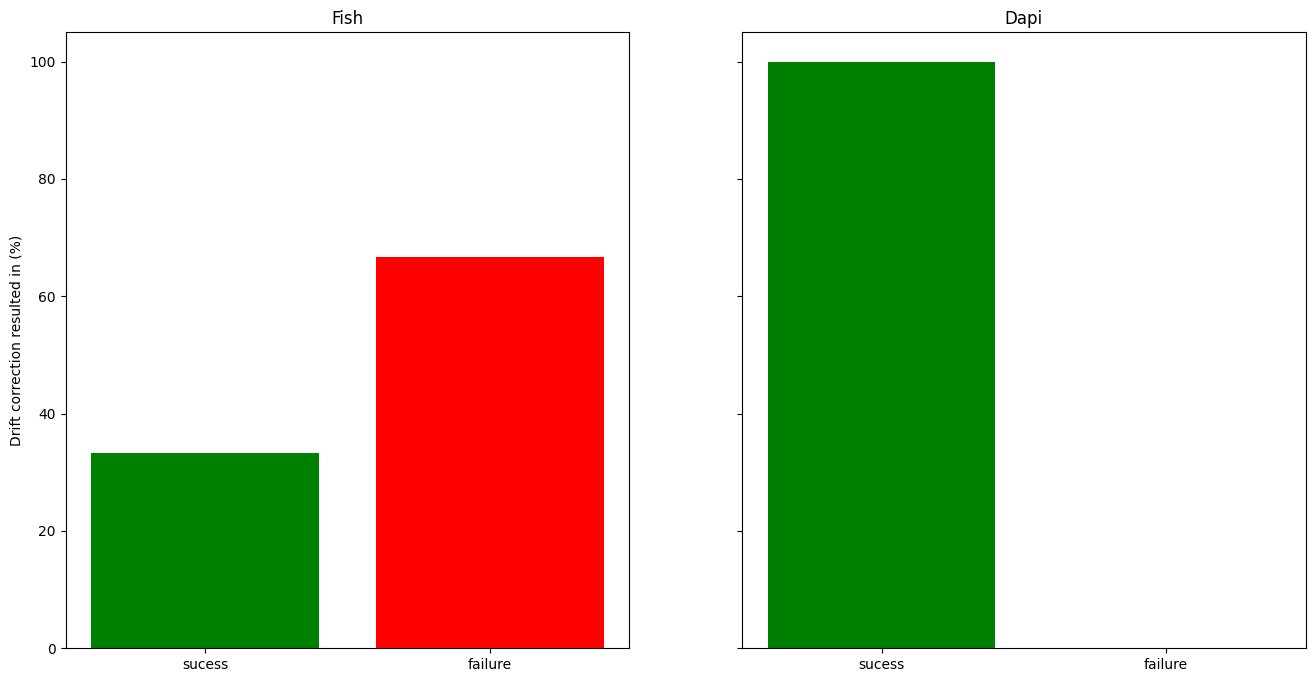

In [7]:
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)
axes : 'list[plt.Axes]'
fish, dapi = axes

fish.bar(['sucess', 'failure'], [fish_sucess_percentage, fish_fail_percentage], color=['green', 'red'])
dapi.bar(['sucess', 'failure'], [dapi_sucess_percentage, dapi_fail_percentage], color=['green', 'red'])

fish.set_title('Fish')
dapi.set_title('Dapi')
fish.set_ylabel("Drift correction resulted in (%)")

plt.show()

### Per cycle

In [8]:
Drift['sucess'] = (Drift['drift_z'] != 0) | (Drift['drift_y'] != 0) | (Drift['drift_x'] | 0)
per_cycle_sucess = Drift.loc[~Drift['error'].isna()].groupby(['drift_type','cycle']).agg({
    'sucess' : ['sum','count'],
})

per_cycle_sucess.columns = ['sucess', 'total']
per_cycle_sucess['sucess_percentage'] = per_cycle_sucess['sucess']*100/per_cycle_sucess['total']
per_cycle_sucess

sucess  total  sucess_percentage
drift_type cycle                                  
dapi       0          10     10              100.0
fish       1           9     10               90.0
           2           9     10               90.0
           3          10     10              100.0
           4           9     10               90.0
           5           9     10               90.0
           6           8     10               80.0
           7           6     10               60.0
           8           5     10               50.0
           9           2     10               20.0
           10          2     10               20.0
           11          1     10               10.0
           12          0     10                0.0
           13          0     10                0.0
           14          0     10                0.0
           15          0     10                0.0
           16          0     10                0.0
           17          0     10                0.0
           18          0     10                0.0
           19          0     10                0.0
           20          0     10                0.0
           21          0     10                0.0

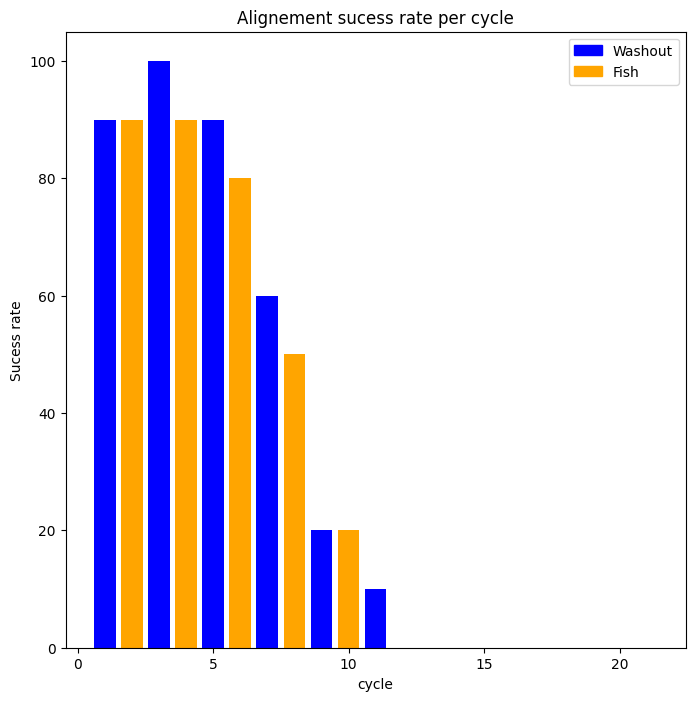

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

X = per_cycle_sucess.loc['fish'].index
Y = per_cycle_sucess.loc['fish']['sucess_percentage']
color = ['blue','orange']
labels = ['fish', 'washout']

legend_symb = [p.Rectangle((0,0),0,1, color= 'blue'), p.Rectangle((0,0),0,1, color= 'orange')]
plt.legend(legend_symb,['Washout','Fish'])

ax.bar(X, Y, color=color)
ax.set_ylabel('Sucess rate')
ax.set_xlabel('cycle')
ax.set_title('Alignement sucess rate per cycle')

plt.show()

## Drift distance

In [10]:
def compute_euclidian_drift(df: pd.DataFrame, voxel_size) :
    df.loc[:,['drift_z', 'drift_y', 'drift_x']] *= voxel_size
    df_sq = df.apply(np.square).sum(axis=1)
    df['euclidian_drift'] = df_sq.apply(np.sqrt)
    return df

In [11]:
fish_drift = Drift[(~Drift['error'].isna()) & (Drift['drift_type'] == 'fish')].loc[:,['cycle','drift_z', 'drift_y', 'drift_x']]
fish_drift = compute_euclidian_drift(fish_drift, VOXEL_SIZE)
fish_drift


,cycle,drift_z,drift_y,drift_x,euclidian_drift
2,1,0,194,-194,274.359254
3,2,0,291,0,291.006873
4,3,0,388,-194,433.807561
5,4,0,485,0,485.016495
6,5,0,582,-194,613.502241
...,...,...,...,...,...
234,17,0,0,0,17.000000
235,18,0,0,0,18.000000
236,19,0,0,0,19.000000
237,20,0,0,0,20.000000


In [12]:
dapi_drift = Drift.loc[(~Drift['error'].isna()) & (Drift['drift_type'] == 'dapi')].loc[:,['cycle','drift_z', 'drift_y', 'drift_x']]
dapi_drift = compute_euclidian_drift(dapi_drift, VOXEL_SIZE)
dapi_drift

,cycle,drift_z,drift_y,drift_x,euclidian_drift
1,0,-1600,0,-388,1646.372983
25,0,-1000,0,-388,1072.634141
49,0,-1800,97,-291,1825.949068
73,0,-3000,97,-388,3026.541425
97,0,-1200,97,-291,1238.583869
121,0,-800,97,-291,856.790523
145,0,-1600,194,-291,1637.778068
169,0,-600,194,-194,659.751468
193,0,-600,194,-194,659.751468
217,0,-1600,97,-194,1614.634634


### Absolute drift distance

In [13]:
Z_score = 1.645 #90% confidence interval
T_score = 1.833 #90% confidence interval; n = 10

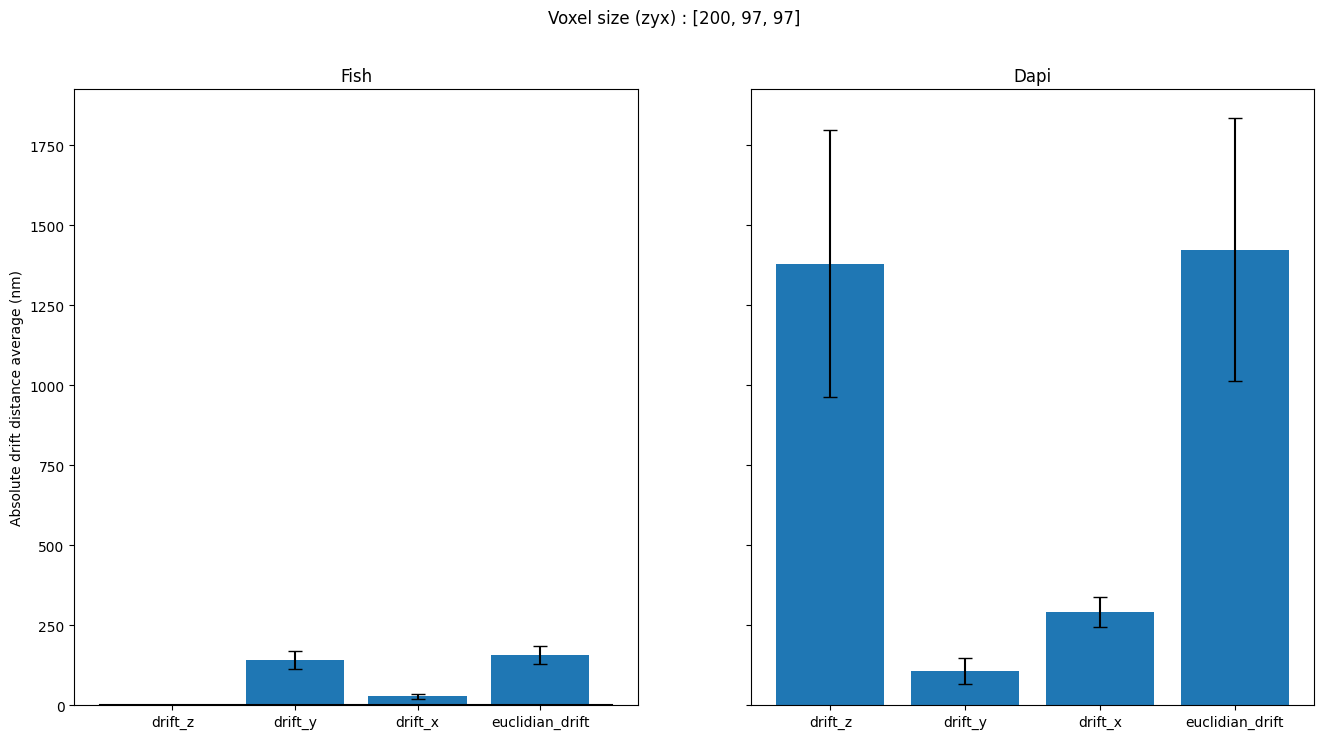

In [14]:
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)
fish, dapi = axes

fish_data = fish_drift.drop(columns='cycle')
dapi_data = dapi_drift.drop(columns='cycle')

fish_mean = fish_data.apply(np.abs).mean(axis=0)

fish_std = fish_data.apply(np.abs).std(axis=0)
fish_count = fish_data.count(axis=0)
confidence_interval = (T_score*fish_std) / fish_count.apply(np.sqrt)

fish.bar(fish_mean.index, fish_mean, yerr=confidence_interval, capsize=5)
xmin,xmax,ymin,ymax = fish.axis()
fish.plot([xmin,xmax], [0,0],'k')
fish.set_title('Fish')
fish.set_ylabel('Absolute drift distance average (nm)')

dapi_mean = dapi_data.apply(np.abs).mean(axis=0)
dapi_std = dapi_data.apply(np.abs).std(axis=0)
dapi_count = dapi_data.count(axis=0)
confidence_interval = (T_score*dapi_std) / dapi_count.apply(np.sqrt)

dapi.bar(dapi_mean.index, dapi_mean, yerr=confidence_interval, capsize=5)
xmin,xmax,ymin,ymax = dapi.axis()
dapi.set_title('Dapi')

fig.suptitle(f"Voxel size (zyx) : {VOXEL_SIZE}")

plt.show()

**Note** : Dapi z stack number is different than reference (fish cycle 0) z stack number

## Mean euclidian drift per cycle

In [15]:
fish_data = fish_drift.groupby('cycle').agg({
    'euclidian_drift' : ['mean', 'std', 'count']
})

fish_data[('euclidian_drift','confidence_interval')] = (T_score * fish_data.loc[:,("euclidian_drift",'std')]) / fish_data.loc[:,("euclidian_drift",'count')].apply(np.sqrt)
fish_data


euclidian_drift                                      
                 mean         std count confidence_interval
cycle                                                      
1          224.039986   83.407197    10           48.346606
2          217.471712   89.952175    10           52.140373
3          432.204257   50.874356    10           29.489091
4          390.571427  144.198013    10           83.583729
5          492.416032  180.959023    10          104.892082
6          371.025531  195.961321    10          113.588097
7          335.682983  286.092711    10          165.832351
8          295.027490  302.553540    10          175.373796
9          134.804922  266.180667    10          154.290425
10         144.504011  283.564006    10          164.366599
11          78.498178  213.447980    10          123.724160
12          12.000000    0.000000    10            0.000000
13          13.000000    0.000000    10            0.000000
14          14.000000    0.000000    10            0.000000
15          15.000000    0.000000    10            0.000000
16          16.000000    0.000000    10            0.000000
17          17.000000    0.000000    10            0.000000
18          18.000000    0.000000    10            0.000000
19          19.000000    0.000000    10            0.000000
20          20.000000    0.000000    10            0.000000
21          21.000000    0.000000    10            0.000000

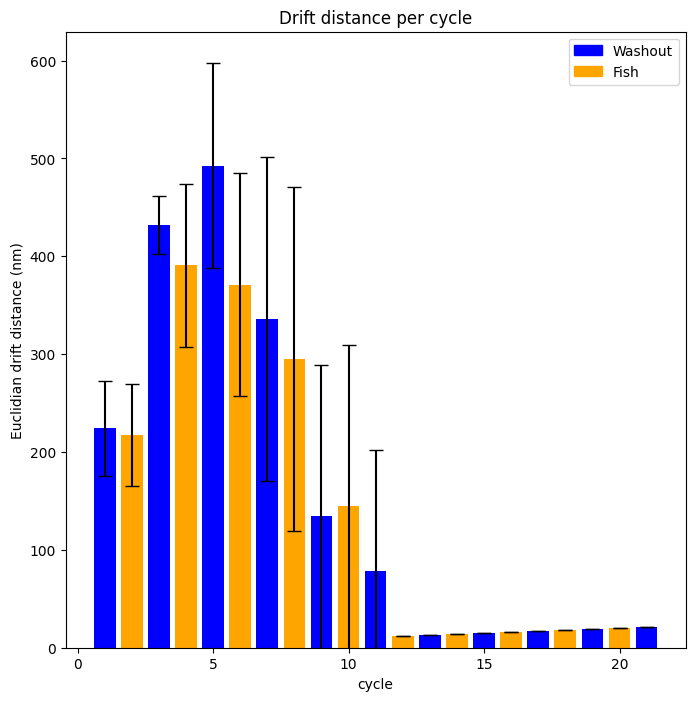

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

X = fish_data.index
Y = fish_data.loc[:,('euclidian_drift','mean')]
error_bar = fish_data.loc[:,('euclidian_drift','confidence_interval')]
color = ['blue','orange']
labels = ['fish', 'washout']

legend_symb = [p.Rectangle((0,0),0,1, color= 'blue'), p.Rectangle((0,0),0,1, color= 'orange')]
plt.legend(legend_symb,['Washout','Fish'])

ax.bar(X, Y, color=color, yerr = error_bar, capsize=5)
ax.set_ylabel('Euclidian drift distance (nm)')
ax.set_xlabel('cycle')
ax.set_title('Drift distance per cycle')

xmin,xmax,ymin,ymax = plt.axis()

ax.set_ylim(0,ymax)

plt.show()